In [69]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
import numpy as np
import pandas as pd
import os
import scipy.stats 
import h5py
from tensorflow.python.keras import backend as K
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import util
import quant_GIA
import tensorflow as tf
from tqdm import tqdm
import tfr_evaluate
from modelzoo import GELU
import re
import quant_GIA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
run_paths = ['paper_runs/binary/basset/run-20210825_040148-nieq47kf/files/best_model.h5',
            'paper_runs/new_models/32_res/run-20211023_095131-w6okxt01/files/best_model.h5',
            'paper_runs/binary/mod_binary/run-20211019_161849-9ygdmjss/files/best_model.h5',
            'paper_runs/basenji/binloss_basenji/run-20210923_162932-56p3xy2p/files/best_model.h5',
            'paper_runs/bpnet/bin_loss_40/run-20211013_133014-ku9mdrht/files/best_model.h5']
cell_lines = 'PC-3'
motif_pairs = ['..TGA.TCA..,..TGA.TCA..', '..TGA.TCA..,..GATAA..', '..TGA.TCA..,..ATAAA..']
command_lines = []
for background in ['dinuc']:
        for run_path in run_paths:
            for motif_pair in motif_pairs:
                command_lines.append('python ./add_GIA_no_pos_opt.py {} {} {} {}'.format(run_path, motif_pair, background, cell_lines))

In [73]:
with open('../add_gia_commands.txt', 'w') as f:
    for item in command_lines:
        f.write("%s\n" % item)

In [81]:
!head -n3 ../add_gia_commands.txt

python ./add_GIA_no_pos_opt.py paper_runs/binary/basset/run-20210825_040148-nieq47kf/files/best_model.h5 ..TGA.TCA..,..TGA.TCA.. dinuc PC-3
python ./add_GIA_no_pos_opt.py paper_runs/binary/basset/run-20210825_040148-nieq47kf/files/best_model.h5 ..TGA.TCA..,..GATAA.. dinuc PC-3
python ./add_GIA_no_pos_opt.py paper_runs/binary/basset/run-20210825_040148-nieq47kf/files/best_model.h5 ..TGA.TCA..,..ATAAA.. dinuc PC-3


# Plot results

In [139]:
motif_dict = {'..GATAA..': 'GATA', 
             '..TGA.TCA..':'AP-1',
             '..ATAAA..': 'ATAAA'}

model_dict = {'run-20211019_161849-9ygdmjss':'mod_binary',
             'run-20210825_040148-nieq47kf': 'basset',
             'run-20211023_095131-w6okxt01': '32_new',
             'run-20210923_162932-56p3xy2p':'basenji',
              'run-20211013_133014-ku9mdrht': 'bpnet'
             }
# result_dirs = glob.glob('add_GIA_interaction/*')
background = 'dinuc'
cell_line = 'PC-3'
base_dir = 'add_GIA_interaction'
result_dirs = [base_dir+d for d in [
            '/run-20210825_040148-nieq47kf',
            '/run-20211019_161849-9ygdmjss',
             '/run-20210923_162932-56p3xy2p',
             '/run-20211013_133014-ku9mdrht',
             '/run-20211023_095131-w6okxt01']  ]     

In [145]:
cell_spec_res = []
for result_dir in result_dirs:

    model_name = model_dict[result_dir.split('/')[-1]]
    all_motif_pairs = set([''.join(d.split('_')[1:]) for d in os.listdir(result_dir) if '_and_' in d])
    for motifs in list(all_motif_pairs):
#     for motifs in ['..TGA.TCA..and..TGA.TCA..']:
        motif1, motif2 = motifs.split('and')
        motif_res_path = os.path.join(result_dir, '{}_{}'.format(cell_line, '_and_'.join([motif1, motif2])), '{}_N1000'.format(background))
        int_df = pd.read_csv(os.path.join(motif_res_path, '1024_best_distance_interaction.csv')).iloc[:,1:]

        polished_names = []
        for m in int_df['motif'].values:
            p = []
            list_of_single_motifs = m.split('&')
            split_m = [single_m.split(' at ') for single_m in list_of_single_motifs]
            for motif, coord in split_m:
                p.append('{} {}'.format([v for k,v in motif_dict.items() if re.match(k, motif.strip())][0], coord))
            polished_names.append('&\n'.join(p))
        int_df['added motif'] = polished_names
        m1_df = int_df.iloc[np.argwhere([True if '1024' in p and '&' not in p else False for p in polished_names]).flatten()]
        m2_df = int_df.iloc[np.argwhere([True if '1024' not in p and '&' not in p else False for p in polished_names]).flatten()]
        sum_diffs = m1_df['mean difference'].values + m2_df['mean difference'].values
        df = pd.DataFrame()
        df['mean difference'] = sum_diffs
        df['cell line'] = m1_df['cell line'].values
        df['motif'] = 'sum'
        df['added motif'] = 'sum'
        int_df = pd.concat([int_df, df])


        int_df['model'] = model_name
        int_df['group'] = motifs
        cell_spec_res.append(int_df[int_df['cell line'] == cell_line])
all_dfs = pd.concat(cell_spec_res)

In [141]:
all_motif_pairs

{'..TGA.TCA..and..ATAAA..',
 '..TGA.TCA..and..GATAA..',
 '..TGA.TCA..and..TGA.TCA..'}

Text(0, 0.5, 'Global importance')

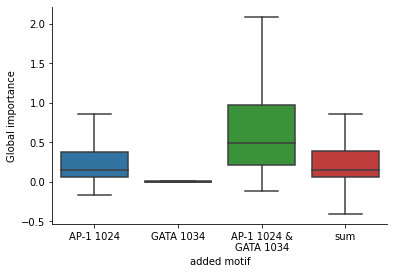

In [149]:
df = all_dfs[(all_dfs['group']=='..TGA.TCA..and..GATAA..')&(all_dfs['model']=='32_new')]
g=sns.boxplot(data=df, x='added motif', y='mean difference', showfliers=False)

# plt.title(df['model'].values[0])
g.spines['top'].set_visible(False)
g.spines['right'].set_visible(False)
plt.ylabel('Global importance')


Text(0, 0.5, '')

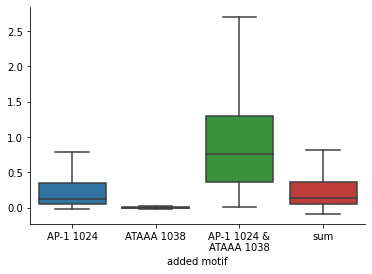

In [153]:
df = all_dfs[(all_dfs['group']=='..TGA.TCA..and..ATAAA..')&(all_dfs['model']=='32_new')]
g=sns.boxplot(data=df, x='added motif', y='mean difference', showfliers=False)
g.spines['top'].set_visible(False)
g.spines['right'].set_visible(False)
plt.ylabel('')

Text(0, 0.5, '')

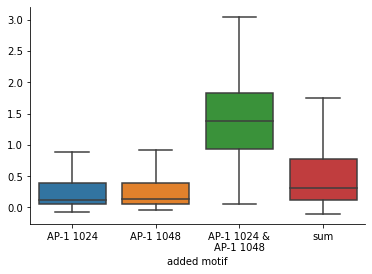

In [152]:
df = all_dfs[(all_dfs['group']=='..TGA.TCA..and..TGA.TCA..')&(all_dfs['model']=='32_new')]
g=sns.boxplot(data=df, x='added motif', y='mean difference', showfliers=False)
g.spines['top'].set_visible(False)
g.spines['right'].set_visible(False)
plt.ylabel('')

/home/shush/tf_2/lib/python3.7/site-packages/seaborn/categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


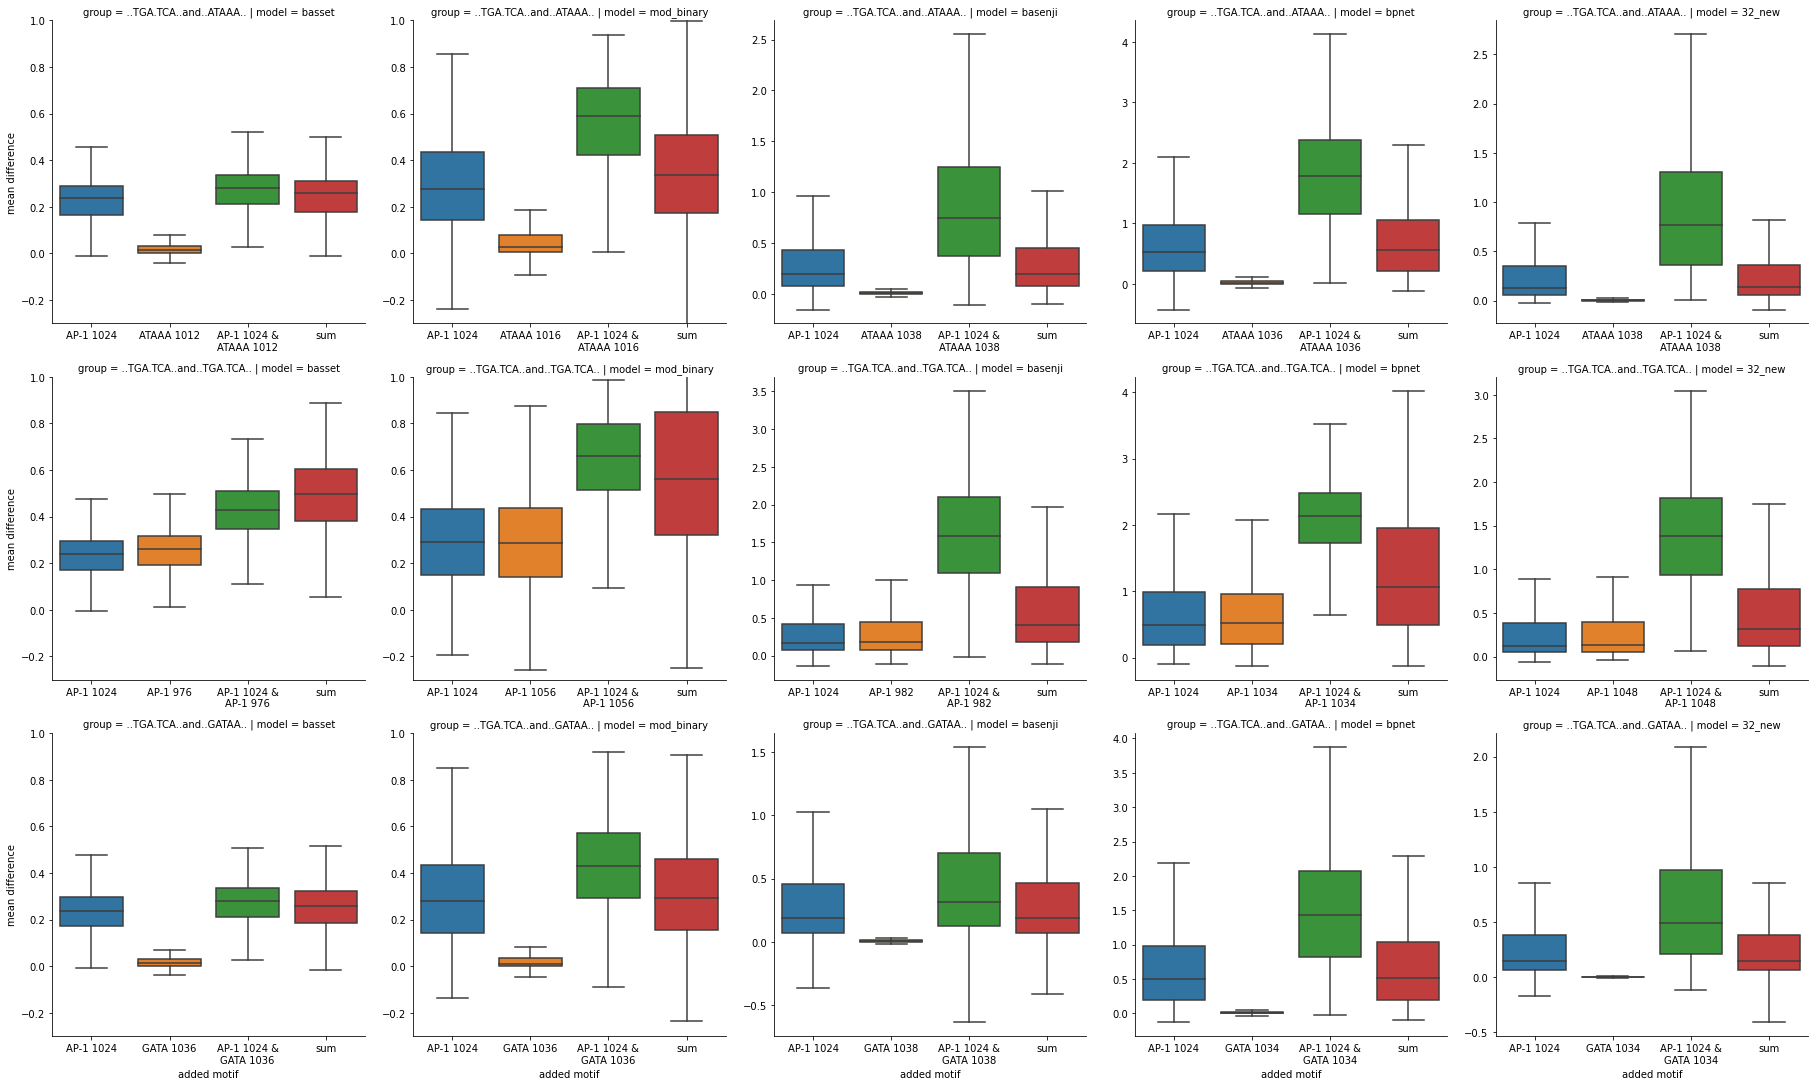

In [74]:

# df = list(iter(all_dfs.groupby('group')))[0][1]
g = sns.catplot(data=all_dfs, x='added motif',y='mean difference', row='group', sharex=False,
            kind='box', sharey=False, col='model',showfliers = False, palette='tab10')
axs = g.axes
for r in range(axs.shape[0]):
    for c in range(2):
        axs[r][c].set_ylim(-0.3,1)
        
# axs[0][:].set_ylim(-0.3,1)
# axs[1][:].set_ylim(-0.3,1)
# plt.xticks(rotation=90)

In [177]:
set(new_mod['group'])

{'..TGA.TCA..and..ATAAA..',
 '..TGA.TCA..and..GATAA..',
 '..TGA.TCA..and..TGA.TCA..'}

/home/shush/tf_2/lib/python3.7/site-packages/seaborn/categorical.py:3737: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/shush/tf_2/lib/python3.7/site-packages/seaborn/categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


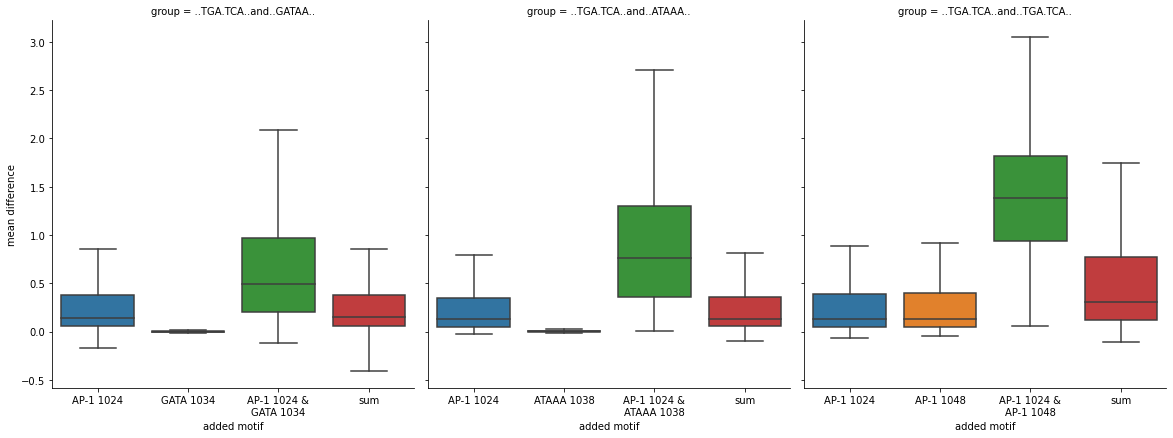

In [191]:

new_mod = all_dfs[all_dfs['model']=='32_new']
g = sns.catplot(data=new_mod, x='added motif',y='mean difference', 
            showfliers = False, kind='box', col='group', sharex=False, col_order=['..TGA.TCA..and..GATAA..',
                                                                             '..TGA.TCA..and..ATAAA..',
                                                                             '..TGA.TCA..and..TGA.TCA..'],
               size=6, aspect=0.9)
plt.savefig(os.path.join(plot_dir, 'GIA_c.svg'))

In [ ]:
def boxplot_with_test(data, x, y, pairs):
    from scipy.stats import mannwhitneyu
    from statannotations.Annotator import Annotator
    plotting_parameters = {
                            'data':    data,
                            'x':       x,
                            'y':       y}
    pvalues = [mannwhitneyu(data[data[x]==pair[0]][y],
                            data[data[x]==pair[1]][y]).pvalue for pair in pairs]
    ax = sns.boxplot(**plotting_parameters)
    # Add annotations
    annotator = Annotator(ax, pairs, **plotting_parameters)
    annotator.set_pvalues(pvalues)
    annotator.annotate();

# Flanks

In [76]:
testset, targets = tfr_evaluate.collect_whole_testset(coords=True)
C, X, Y = util.convert_tfr_to_np(testset, 3)
X_set = quant_GIA.select_set('all_threshold', C, X, Y)


In [156]:
plot_dir = util.make_dir('../paper_figures')

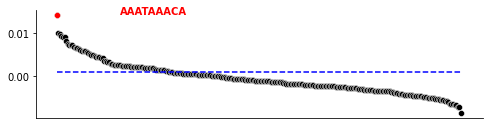

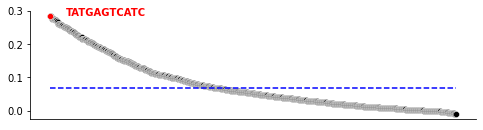

In [164]:
for motif_insert in [[('ATAAA', 1024)], [('TGA', 1024), ('TCA', 1024+len('TGA')+1)]]:
    run_name = 'run-20211023_095131-w6okxt01'

    motif_pattern = '.'.join([m[0] for m in motif_insert])
    run_path = glob.glob('../paper_runs/*/*/{}/files/best_model.h5'.format(run_name))[0]
    model = tf.keras.models.load_model(run_path, custom_objects={"GELU": GELU})
    gi = quant_GIA.GlobalImportance(model, targets)
    gi.set_null_model('dinuc', base_sequence=X_set, num_sample=1000, seed=42)
    diff = gi.embed_predict_quant_effect(motif_insert)

    plt.figure(figsize=[8,2])
    ata_flanks = pd.read_csv('add_GIA_interaction/{}/PC-3_..{}../dinuc_N1000/flanks.csv'.format(run_name, motif_pattern))
    sorted_flanks = ata_flanks[ata_flanks['cell line']==cell_line].sort_values('mean difference')[::-1]
    sns.scatterplot(data=sorted_flanks, 
                    x='motif', y='mean difference', color='k')
    plt.xticks([])
    a = sns.scatterplot(x=[0],y=[sorted_flanks.iloc[0,1]], color='r')
    plt.text(40, sorted_flanks.iloc[0,1], sorted_flanks.iloc[0,0], 
             horizontalalignment='left', size='medium', color='red', weight='semibold')
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
#     plt.ylabel('Global importance')
#     plt.xlabel('motif flanks')
    plt.ylabel('')
    plt.xlabel('')
    plt.hlines(diff[:,:,13].mean(),0, len(sorted_flanks['motif'].values), 'blue', linestyles='--', label='no flanks')
    plt.savefig(os.path.join(plot_dir, 'GIA_a_{}.svg'.format(motif_pattern)))


# distance

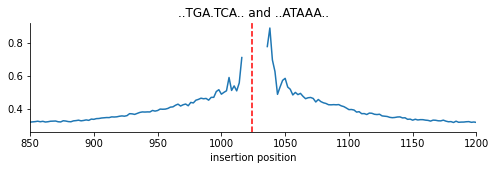

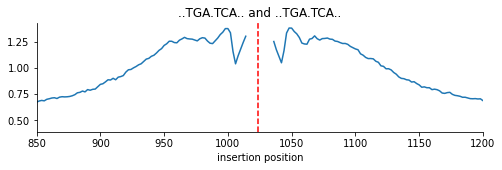

In [168]:

m1_s = 1024
m1 = '..TGA.TCA..'

for m2 in ['..ATAAA..', '..TGA.TCA..']:
    cell_line = 'PC-3'
    df = pd.read_csv('add_GIA_interaction/run-20211023_095131-w6okxt01/{}_{}_and_{}/dinuc_N1000/1024_distance.csv'.format(cell, m1, m2))
    df['insertion position'] = [int(d.split('_')[1]) for d in df['motif 2']]
    dist_df = df[df['cell line']==cell_line].reset_index()
   

    pos = dist_df['insertion position'].values
    for p in np.argwhere((pos>m1_s-len(m2)+1)&(pos<m1_s+len(m1))).flatten():
        dist_df.iloc[p, 2] = np.nan

    plt.figure(figsize=[8,2])
    ax = sns.lineplot(data=dist_df, x='insertion position', y='mean difference')

    plt.ylabel('')
    plt.xlim(850, 1200)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title('{} and {}'.format(m1, m2))
    plt.axvline(x=1024, ymin=0, ymax=1, c='r', linestyle='--')
    plt.savefig(os.path.join(plot_dir, 'GIA_b_{}.svg'.format(m2)))
# plt.ylim(0.6,1.4)
# plt.legend(bbox_to_anchor=(1,1))

# occlude

In [53]:
run_paths = ['paper_runs/binary/basset/run-20210825_040148-nieq47kf/files/best_model.h5',
            'paper_runs/new_models/32_res/run-20211023_095131-w6okxt01/files/best_model.h5',
            'paper_runs/binary/mod_binary/run-20211019_161849-9ygdmjss/files/best_model.h5',
            'paper_runs/basenji/binloss_basenji/run-20210923_162932-56p3xy2p/files/best_model.h5',
            'paper_runs/bpnet/bin_loss_40/run-20211013_133014-ku9mdrht/files/best_model.h5']
cell_lines = 'all'
motif_pairs = ['TGA.TCA,GATAA', 'TGA.TCA,ATAAA']
command_lines = []
for background in ['dinuc']:
        for run_path in run_paths:
            for motif_pair in motif_pairs:
                command_lines.append('python ./occlude_motifs_GIA.py {} {} {} {}'.format(run_path, motif_pair, background, cell_lines))

In [54]:
with open('../remove_gia_commands.sh', 'w') as f:
    for item in command_lines:
        f.write("%s\n" % item)

In [24]:
motif_dict = {'..GATAA..': 'GATA', 
             '..TGA.TCA..':'AP-1',
             '..ATAAA..': 'ATAAA'}
base_dir = 'occlude_GIA_fin'
model_dict = {base_dir+'/run-20211019_161849-9ygdmjss':'mod_binary',
             base_dir+'/run-20210825_040148-nieq47kf': 'basset',
             base_dir+'/run-20211023_095131-w6okxt01': '32_new',
             base_dir+'/run-20210923_162932-56p3xy2p':'basenji',
              base_dir+'/run-20211013_133014-ku9mdrht': 'bpnet'
             }
# result_dirs = glob.glob('add_GIA_interaction/*')
background = 'dinuc'
cell_line = 'PC-3'
result_dirs = [base_dir+d for d in [
            '/run-20210825_040148-nieq47kf',
            '/run-20211019_161849-9ygdmjss',
             '/run-20210923_162932-56p3xy2p',
             '/run-20211013_133014-ku9mdrht',
             '/run-20211023_095131-w6okxt01']  ]          
            

In [30]:
cell_spec_res = []
for result_dir in result_dirs:
    model_name = model_dict[result_dir]
    all_motif_pairs = set([''.join(d.split('all_')[-1]) for d in os.listdir(result_dir) if 'all_' in d])
    for motifs in list(all_motif_pairs):
#     for motifs in ['..TGA.TCA..and..TGA.TCA..']:
        motif1, motif2 = motifs.split(',')
        motif_res_path = os.path.join(result_dir, 'all_'+motifs, '{}_N1000'.format(background))
        files = os.listdir(motif_res_path)
        assert len(files) == 1, 'incorrect number of files!'
        int_df = pd.read_csv(os.path.join(motif_res_path, files[0]))
        
        int_df['model'] = model_name
        int_df['group'] = motifs
        cell_spec_res.append(int_df[int_df['cell line'] == cell_line])
all_dfs = pd.concat(cell_spec_res)

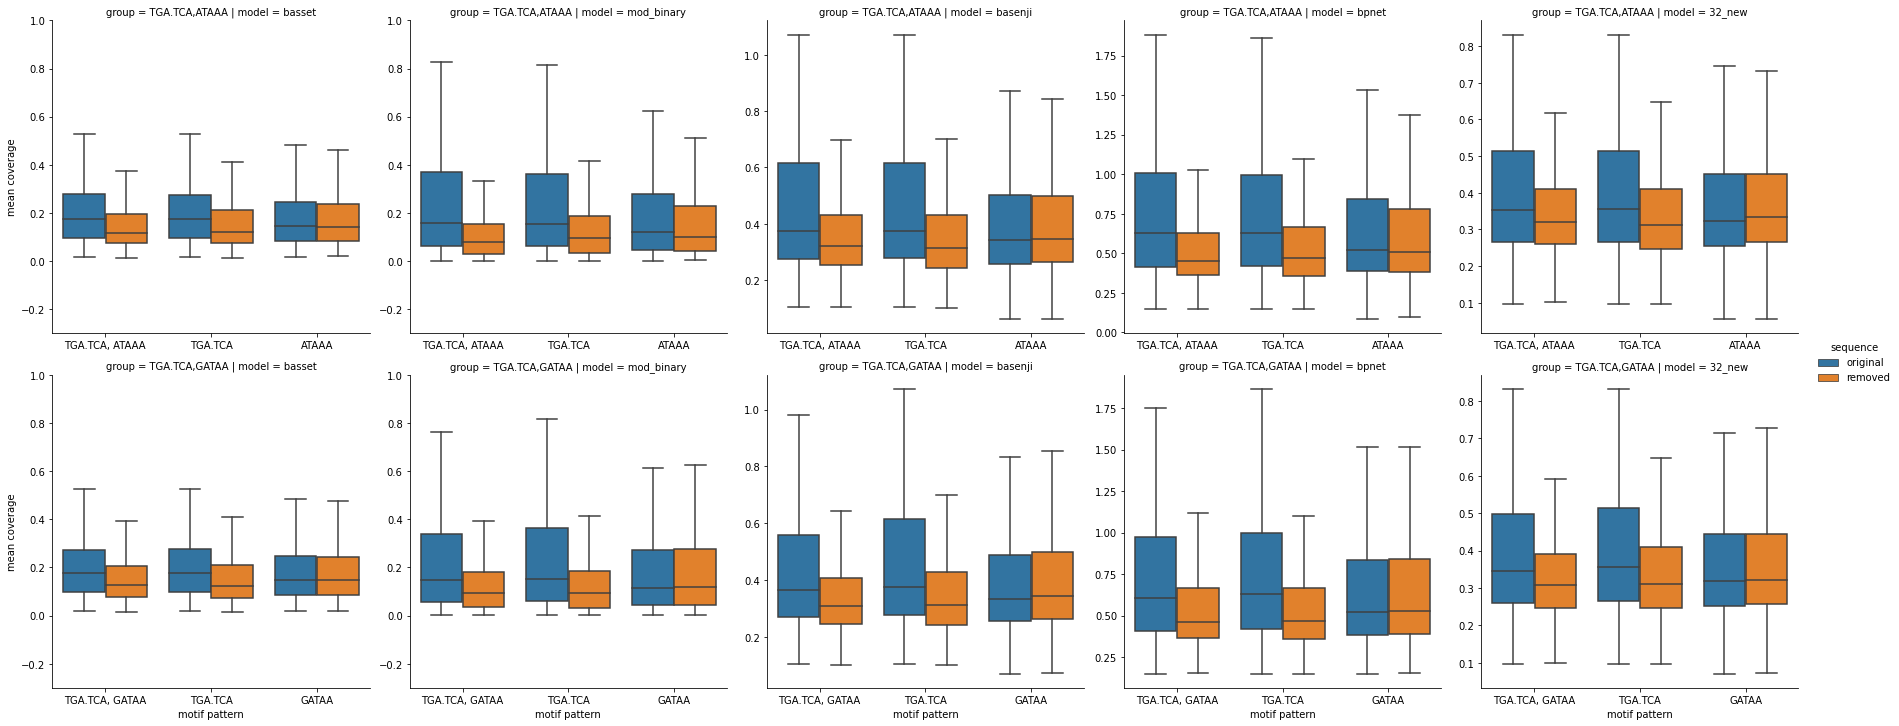

In [28]:
g = sns.catplot(data=all_dfs, x='motif pattern',y='mean coverage', row='group', sharex=False, hue='sequence',
            kind='box', sharey=False, col='model',showfliers = False, palette='tab10')
axs = g.axes
for r in range(axs.shape[0]):
    for c in range(2):
        axs[r][c].set_ylim(-0.3,1)

## multiple TGA.TCA occlusion

In [3]:
testset, targets = tfr_evaluate.collect_whole_testset(coords=True)
C, X, Y = util.convert_tfr_to_np(testset, 3)
X_set = quant_GIA.select_set('all_threshold', C, X, Y)

In [133]:
run_paths = ['paper_runs/binary/basset/run-20210825_040148-nieq47kf/files/best_model.h5',
            'paper_runs/new_models/32_res/run-20211023_095131-w6okxt01/files/best_model.h5',
            'paper_runs/binary/mod_binary/run-20211019_161849-9ygdmjss/files/best_model.h5',
            'paper_runs/basenji/binloss_basenji/run-20210923_162932-56p3xy2p/files/best_model.h5',
            'paper_runs/bpnet/bin_loss_40/run-20211013_133014-ku9mdrht/files/best_model.h5']
gi = quant_GIA.GlobalImportance(model, targets)
for run_path in run_paths[1:2]:
    model = tf.keras.models.load_model('../'+run_path, custom_objects={"GELU": GELU})    
    gi.occlude_all_motif_instances(X_set, ['TGA.TCA'], func='mean',
                                      num_sample=10000)



5it [00:00, 49.82it/s]

SUBSETTING SEQUENCES
tandem_motifs_to_remove ['TGA.TCA']
TGA.TCA


10000it [03:30, 47.46it/s]


(127750, 15)
Reshaping to 3D!
(5110, 1, 15)
"get_predictions" took 0.624 mins to execute

"occlude_all_motif_instances" took 4.174 mins to execute



In [ ]:
results = pd.concat(gi.summary_remove_motifs)
results = results[results['cell line']=='PC-3']
results['N instances'] = [int(r) for r in results['N instances'].values]

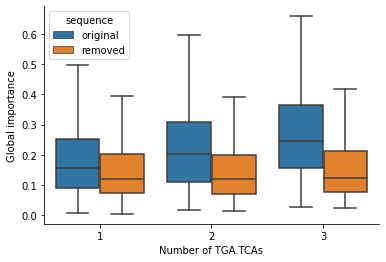

In [138]:
ax = sns.boxplot(data=results[results['N instances']<4], x='N instances', y='mean coverage', 
            showfliers=False, hue='sequence')
plt.ylabel('Global importance')
plt.xlabel('Number of TGA.TCAs')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [ ]:
results = pd.concat(gi.summary_remove_motifs)
results = results[results['cell line']=='PC-3']

In [59]:
results = []
for r, run_path in enumerate(run_paths):
    df = gi.summary_remove_motifs[r]
    df['model'] = model_dict[base_dir+'/'+[i for i in run_path.split('/') if 'run-' in i][0]]
    results.append(df[df['cell line']=='PC-3'])
results = pd.concat(results)    

In [65]:
results['N instances'] = [int(r) for r in results['N instances'].values]

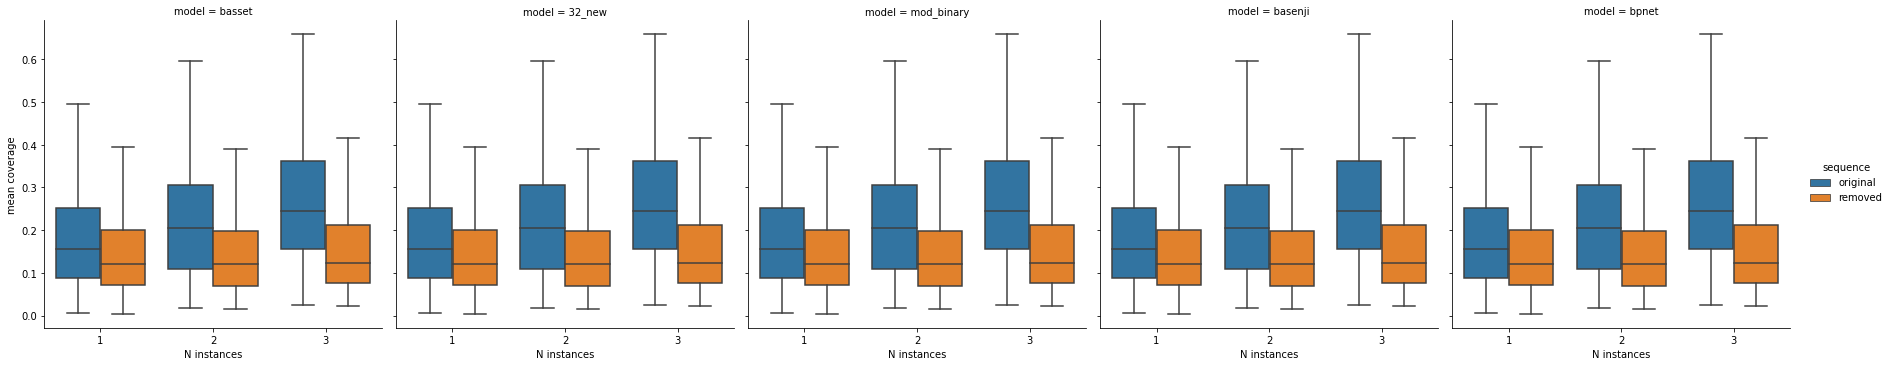

In [67]:
sns.catplot(data=results[results['N instances']<4], x='N instances', y='mean coverage', 
            showfliers=False, kind='box', col='model', hue='sequence')